In [21]:
from matplotlib import pyplot as plt

import diversity_metrics
import numpy as np
import pandas as pd
import scipy
import warnings

# Suppress warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import and clean data

In [2]:
# import data
pc_taxa = pd.read_csv('point-count-species-clean.csv')

# manual cleaning
pc_taxa[['Date']] = pc_taxa[['Date']].replace(to_replace = {'11/1/2023':'11/01/2023',
                                                                  '11/11/23': '11/11/2023',
                                                                  '12/2/2023': '12/02/2023'})
pc_taxa['Date'] = pd.to_datetime(pc_taxa['Date'])
pc_taxa['Species'] = pc_taxa['Species'].str.lower()

valid_pc_data = pd.read_csv('pc-data-with-completeness.csv')
valid_pcs = list(valid_pc_data['PC #'].unique())
pc_taxa = pc_taxa[pc_taxa['PC #'].isin(valid_pcs)]

pc_taxa

,PC #,Date,Location,Time Bin,Species,# Individuals,Notes,Editorial notes,Jon Problem Checker
0,1,2023-10-06,A1,Morning (7-9am),rock pigeon,3.0,NaN,NaN,-
1,1,2023-10-06,A1,Morning (7-9am),anna's hummingbird,3.0,NaN,NaN,-
2,1,2023-10-06,A1,Morning (7-9am),nuttall's woodpecker,1.0,NaN,NaN,-
3,1,2023-10-06,A1,Morning (7-9am),american crow,3.0,NaN,NaN,-
4,1,2023-10-06,A1,Morning (7-9am),dark-eyed junco,2.0,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...
4825,795,2024-04-27,B5,Evening (3-5pm),dark-eyed junco,4.0,NaN,NaN,-
4826,796,2024-04-27,B6,Evening (3-5pm),american crow,4.0,NaN,NaN,-
4827,796,2024-04-27,B6,Evening (3-5pm),common raven,2.0,NaN,NaN,-
4828,796,2024-04-27,B6,Evening (3-5pm),red-breasted nuthatch,1.0,NaN,NaN,-


In [3]:
pc_dates = pc_taxa['Date'].unique()
taxa_seen = sorted(pc_taxa['Species'].unique())

In [4]:
taxa_seen

['accipiter_genus',
 'accipitridae_family',
 "allen's hummingbird",
 'american crow',
 'american goldfinch',
 'american robin',
 'american white pelican',
 "anna's hummingbird",
 'band-tailed pigeon',
 "bewick's wren",
 'black phoebe',
 'brown creeper',
 'brown-headed cowbird',
 'bushtit',
 'buteo_genus',
 'california gull',
 'california scrub-jay',
 'california towhee',
 'cedar waxwing',
 'chestnut-backed chickadee',
 'cliff swallow',
 'columbidae_family',
 'common raven',
 "cooper's hawk",
 'corvidae_family',
 'dark-eyed junco',
 'downy woodpecker',
 'falco_genus',
 'fox sparrow',
 'fringillidae_family',
 'golden-crowned kinglet',
 'golden-crowned sparrow',
 'hairy woodpecker',
 'hermit thrush',
 'hirundinidae_family',
 'house finch',
 "hutton's vireo",
 'larus_genus',
 'lesser goldfinch',
 'mourning dove',
 'northern flicker',
 "nuttall's woodpecker",
 'oak titmouse',
 'orange-crowned warbler',
 'paridae_family',
 'parulidae_family',
 'peregrine falcon',
 'picidae_family',
 'pine si

During surveying, not every individual seen could be identified at the species level taxa. In the below calculations of diversity metrics, higher level taxa observations were included in the analysis.

In [59]:
higher_level_taxa = [
    'accipiter_genus',
    'accipitridae_family',
    'buteo_genus',
    'columbidae_family',
    'corvidae_family',
    'falco_genus',
    'fringillidae_family',
    'hirundinidae_family',
    'larus_genus',
    'paridae_family',
    'parulidae_family',
    'picidae_family',
    'setophaga_genus',
    'sitta_genus',
    'spinus_genus',
    'trochilidae_family',
    'zonotrichia_genus'
]

species_taxa = [t for t in taxa_seen if t not in higher_level_taxa]

### Calculate abundance and frequency for all unique taxa seen

We are measuring abundance in number of survey days seen and frequency in abundance divided by total number of survey days (51). Multiple point counts were done on each day, but we are aggregating all point counts done on the same day.

In [6]:
taxa_abundances = [diversity_metrics.abundance_days_seen(pc_taxa, taxon) for taxon in taxa_seen]
taxa_frequencies = [diversity_metrics.frequency_days_seen(pc_taxa, taxon) for taxon in taxa_seen]

In [7]:
abundance_and_frequency = pd.DataFrame()
abundance_and_frequency['Taxon'] = taxa_seen
abundance_and_frequency['Abundance'] = taxa_abundances
abundance_and_frequency['Frequency'] = taxa_frequencies
abundance_and_frequency

,Taxon,Abundance,Frequency
0,accipiter_genus,3,0.065217
1,accipitridae_family,2,0.043478
2,allen's hummingbird,1,0.021739
3,american crow,46,1.000000
4,american goldfinch,1,0.021739
...,...,...,...
70,white-throated swift,3,0.065217
71,wild turkey,1,0.021739
72,wilson's warbler,1,0.021739
73,yellow-rumped warbler,39,0.847826


In [56]:
# Frequency -> mean and variance
mean_frequency = np.mean(abundance_and_frequency['Frequency'])
frequency_variance = np.var(abundance_and_frequency['Frequency'])
print("Mean Frequency across all taxa:", mean_frequency)
print("Frequency Variance across all taxa:", frequency_variance)

Mean Frequency across all taxa: 0.3640579710144928
Frequency Variance across all taxa: 0.1324145347616047


In [57]:
abundance_and_frequency.sort_values("Frequency")

,Taxon,Abundance,Frequency
27,falco_genus,1,0.021739
55,setophaga_genus,1,0.021739
56,sharp-shinned hawk,1,0.021739
24,corvidae_family,1,0.021739
59,spinus_genus,1,0.021739
...,...,...,...
19,chestnut-backed chickadee,46,1.000000
7,anna's hummingbird,46,1.000000
5,american robin,46,1.000000
3,american crow,46,1.000000


The observed mean frequency of taxa across the 7-month survey period was 0.364, and the observed variance across the survey period was 0.132. Compared to the Spring 2023 data (mean 0.306 and variance 0.0926), the data across this survey period had a higher mean and a higher variance, although this comparison is not the best, as it includes higher level taxa.

Across all the valid point counts (as defined in `data-cleaning.ipynb`), six taxa that were seen in every valid survey day:
- American Crow (*Corvus brachyrhynchos*)
- American Robin (*Turdus migratorius*)
- Anna's Hummingbird (*Calypte anna*)
- Chestnut-backed Chickadee (*Poecile rufescens*)
- Dark-eyed Junco (*Junco hyemalis*)\*
- House Finch (*Haemorhous mexicanus*)

\*All subspecies of the Dark-eyed Junco were consolidated into one species-level taxon.

Note that frequency is being calculated as a measure of days seen divided by *total* valid survey days, and the number of valid survey days (46) is less than the number of total days surveyed (50).

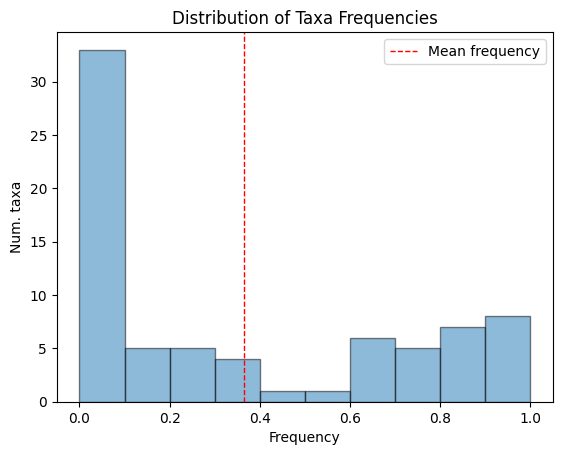

In [78]:
# Plot histogram of taxa frequencies and average frequency
plt.hist(x = abundance_and_frequency['Frequency'], bins = np.linspace(0, 1, 11), alpha = 0.5, histtype='bar', ec='black')
plt.axvline(mean_frequency, color='r', linestyle='dashed', linewidth=1, label = "Mean frequency")
plt.xlabel("Frequency")
plt.ylabel("Num. taxa")
plt.title("Distribution of Taxa Frequencies")
plt.legend()

The histogram above shows a strongly right-skewed distribution of taxa frequencies, with many taxa seen over the survey period having frequencies 0.1 or less. Therefore, we might have seen a lot of rarer species across the survey period. However, this bin includes taxa that are higher than the spcecies level (e.g. "corvidae_family"), which, with the exception of the *Larus* genus, all have frequencies less than 0.5. 

All of the other higher level taxa have such low frequencies because of the rarity of cases in which the observers were unable to ascertain a species level identification. The *Larus* genus is an exception because different species of gulls are notoriously difficult to distinguish.

In [11]:
abundance_and_frequency[abundance_and_frequency['Taxon'].isin(higher_level_taxa)].sort_values(by = 'Frequency')

,Taxon,Abundance,Frequency
59,spinus_genus,1,0.021739
21,columbidae_family,1,0.021739
24,corvidae_family,1,0.021739
27,falco_genus,1,0.021739
55,setophaga_genus,1,0.021739
1,accipitridae_family,2,0.043478
57,sitta_genus,2,0.043478
63,trochilidae_family,2,0.043478
0,accipiter_genus,3,0.065217
74,zonotrichia_genus,3,0.065217


In [12]:
abundance_and_frequency.to_csv('all-taxa-abundance-and-frequency.csv')

The abundance and frequency data can be seen in `all-taxa-abundance-and-frequency.csv`.

### Calculate Simpson and Shannon Diversity for all dates

In [13]:
date_simpson_diversity = [diversity_metrics.simpson_diversity(pc_taxa, date) for date in pc_dates]
date_shannon_diversity = [diversity_metrics.shannon_diversity(pc_taxa, date) for date in pc_dates]

In [14]:
simpson_and_shannon = pd.DataFrame()
simpson_and_shannon['Date'] = pc_dates
simpson_and_shannon['Simpson Diversity'] = date_simpson_diversity
simpson_and_shannon['Shannon Diversity'] = date_shannon_diversity
first_date = simpson_and_shannon['Date'][0]
simpson_and_shannon['Days Since First PC'] = pd.Series([(date - first_date).days for date in simpson_and_shannon['Date']])
simpson_and_shannon

,Date,Simpson Diversity,Shannon Diversity,Days Since First PC
0,2023-10-06,0.831172,2.172987,0
1,2023-10-12,0.854499,2.348290,6
2,2023-10-14,0.878946,2.533530,8
3,2023-10-20,0.752022,2.058189,14
4,2023-10-22,0.885835,2.657016,16
5,2023-10-25,0.789655,2.236598,19
6,2023-10-28,0.864841,2.501920,22
7,2023-10-31,0.889235,2.743488,25
8,2023-11-01,0.694013,1.913557,26
9,2023-11-05,0.897261,2.725319,30


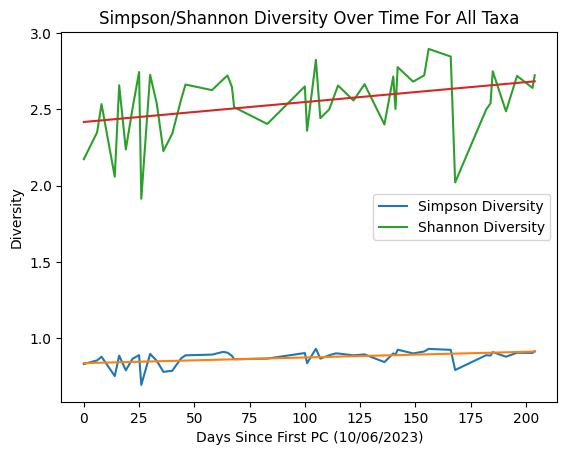

In [80]:
# Plot Simpson and Shannon Diversity, plus best fit lines.
# The scipy.stats.linregress method is used for easier downstream analysis.
plt.plot(simpson_and_shannon['Days Since First PC'], date_simpson_diversity, label = "Simpson Diversity")

simpson_regression_results = scipy.stats.linregress(simpson_and_shannon['Days Since First PC'],
                                                    date_simpson_diversity,
                                                    alternative = 'greater')
simpson_m, simpson_b = simpson_regression_results.slope, simpson_regression_results.intercept
plt.plot(simpson_and_shannon['Days Since First PC'],
         simpson_m * simpson_and_shannon['Days Since First PC'] + simpson_b)

plt.plot(simpson_and_shannon['Days Since First PC'], date_shannon_diversity, label = "Shannon Diversity")

shannon_regression_results = scipy.stats.linregress(simpson_and_shannon['Days Since First PC'],
                                                    date_shannon_diversity,
                                                    alternative = 'greater')
shannon_m, shannon_b = shannon_regression_results.slope, shannon_regression_results.intercept
plt.plot(simpson_and_shannon['Days Since First PC'],
         shannon_m * simpson_and_shannon['Days Since First PC'] + shannon_b)

plt.title("Simpson/Shannon Diversity Over Time For All Taxa")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Diversity")
plt.legend()

Above, I plotted the Simpson/Shannon Diversity over the entire 7-month survey period (October 2023-April 2024), plus their best fit lines. Both Simpson and Shannon diversity had peaks and valleys in similar places, but the peaks and valleys were both more pronounced in Shannon Diversity. 

The Shannon Diversity also had a much higher variance compared to Simpson Diversity, but I believe that this difference is due to the differences in how the two measures are calculated.

In [47]:
# Calculate mean and variance for Simpson and Shannon Diversity
mean_simpson, var_simpson = np.mean(simpson_and_shannon['Simpson Diversity']), np.var(simpson_and_shannon['Simpson Diversity'])
mean_shannon, var_shannon = np.mean(simpson_and_shannon['Shannon Diversity']), np.var(simpson_and_shannon['Shannon Diversity'])

print("Mean Simpson Diversity:", mean_simpson)
print("Simpson Diversity Variance:", var_simpson)
print("Mean Shannon Diversity:", mean_shannon)
print("Shannon Diversity Variance:", var_shannon)

Mean Simpson Diversity: 0.8727121104255795
Simpson Diversity Variance: 0.0023853446929688214
Mean Shannon Diversity: 2.543487058865343
Shannon Diversity Variance: 0.047201056162424544


In [48]:
# Retrieve the p-values of the slopes for Simpson and Shannon Diversity
print("Simpson Diversity Slope p-value:", simpson_regression_results.pvalue)
print("Shannon Diversity Slope p-value:", shannon_regression_results.pvalue)

Simpson Diversity Slope p-value: 0.0003940856440049634
Shannon Diversity Slope p-value: 0.00497189031565625


Using a p-value of 0.05 and a one-sided Wald Test with t-distribution of the test statistic (as described in the scipy documentation for the method) for both Simpson and Shannon Diversity, we can conclude that Simpson and Shannon Diversity both underwent significant increases over the survey period.

### Calculate Alpha Diversity values across survey period

In [17]:
alpha_diversity = pd.DataFrame()
alpha_diversity['Date'] = pc_dates
alpha_diversity['Alpha Diversity'] = [diversity_metrics.alpha_diversity(pc_taxa, date) for date in pc_dates]
alpha_diversity['Days Since First PC'] = simpson_and_shannon['Days Since First PC']
alpha_diversity

,Date,Alpha Diversity,Days Since First PC
0,2023-10-06,1.203121,0
1,2023-10-12,1.170276,6
2,2023-10-14,1.137727,8
3,2023-10-20,1.329748,14
4,2023-10-22,1.128879,16
5,2023-10-25,1.266376,19
6,2023-10-28,1.156282,22
7,2023-10-31,1.124562,25
8,2023-11-01,1.440896,26
9,2023-11-05,1.114503,30


In [97]:
mean_alpha = np.mean(alpha_diversity['Alpha Diversity'])
var_alpha = np.var(alpha_diversity['Alpha Diversity'])

print("Mean Alpha Diversity:", mean_alpha)
print("Alpha Diversity Variance:", var_alpha)

Mean Alpha Diversity: 1.1498579024247997
Alpha Diversity Variance: 0.005158805592517431


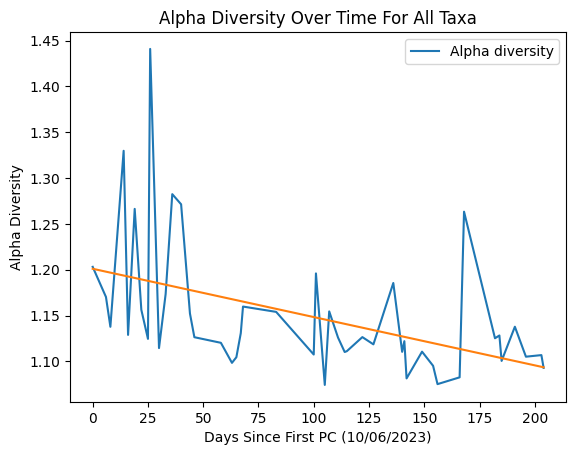

In [81]:
# Plot Alpha Diversity for each date, plus best fit line.
# As described earlier, the scipy.stats.linregress method is used for easier downstream analysis.

plt.plot(alpha_diversity['Days Since First PC'], alpha_diversity['Alpha Diversity'], label = "Alpha diversity")

alpha_diversity_regression_results = scipy.stats.linregress(alpha_diversity['Days Since First PC'],
                                                            alpha_diversity['Alpha Diversity'],
                                                            alternative = 'less')
alpha_m, alpha_b = alpha_diversity_regression_results.slope, alpha_diversity_regression_results.intercept
plt.plot(alpha_diversity['Days Since First PC'],
         alpha_m * alpha_diversity['Days Since First PC'] + alpha_b)

plt.title("Alpha Diversity Over Time For All Taxa")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Alpha Diversity")
plt.legend()

The above graph displays the Alpha Diversity for all taxa plotted over time, starting from the first point count. While the variance seems to be high, there is a clear downward trend across the entire survey period. Notably, this trend differs from the increases in Simpson and Shannon Diversity.

Because Alpha Diversity is calculated as 1/(Simpson Diversity), these trends make sense numerically. In order to explain qualitatively why this difference makes sense, we must first consider the definition of Simpson Diversity as the probability that two individuals chosen at random are of different species. (TODO: I am a little confused about this so I will probably follow up with Sierra and Leena about this. Hopefully they can explain it in a much more articulate way than me.)

In [43]:
# Retrieve the p-value of the slope for alpha diversity
print("Alpha Diversity Slope p-value:", alpha_diversity_regression_results.pvalue)

Alpha Diversity Slope p-value: 0.0006572786841119399


I am using a p-value of 0.05 for the significance analysis. The p-value was calculated using a Wald Test with t-distribution of the test statistic (as described in the scipy documentation for the method, similarly as to the Simpson and Shannon Diversity analysis above) where the null hypothesis was that `alpha_m` = 0. Because the p-value = 0.000657 \< 0.05, we can safely reject the null hypothesis and say that alpha diversity experienced a significant decrease over the survey period.

### Calculate abundance and frequency for all unique species-level taxa seen

We decided to run another version of the analysis without the higher-level (i.e. genus and family) taxa observations because (TODO: insert explanation here). After filtering for only species-level observations, 4528 rows out of 4709 total remained.

In [52]:
pc_species_only = pc_taxa[~ pc_taxa['Species'].isin(higher_level_taxa)]
pc_species_only

,PC #,Date,Location,Time Bin,Species,# Individuals,Notes,Editorial notes,Jon Problem Checker
0,1,2023-10-06,A1,Morning (7-9am),rock pigeon,3.0,NaN,NaN,-
1,1,2023-10-06,A1,Morning (7-9am),anna's hummingbird,3.0,NaN,NaN,-
2,1,2023-10-06,A1,Morning (7-9am),nuttall's woodpecker,1.0,NaN,NaN,-
3,1,2023-10-06,A1,Morning (7-9am),american crow,3.0,NaN,NaN,-
4,1,2023-10-06,A1,Morning (7-9am),dark-eyed junco,2.0,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...
4825,795,2024-04-27,B5,Evening (3-5pm),dark-eyed junco,4.0,NaN,NaN,-
4826,796,2024-04-27,B6,Evening (3-5pm),american crow,4.0,NaN,NaN,-
4827,796,2024-04-27,B6,Evening (3-5pm),common raven,2.0,NaN,NaN,-
4828,796,2024-04-27,B6,Evening (3-5pm),red-breasted nuthatch,1.0,NaN,NaN,-


### Calculate abundance and frequency for all unique taxa seen

As mentioned earlier, we are measuring abundance in number of survey days seen and frequency in abundance divided by total number of survey days (51). Multiple point counts were done on each day, but we are aggregating all point counts done on the same day.

In [70]:
species_abundances = [diversity_metrics.abundance_days_seen(pc_species_only, taxon) for taxon in species_taxa]
species_frequencies = [diversity_metrics.frequency_days_seen(pc_species_only, taxon) for taxon in species_taxa]

In [72]:
species_abundance_and_frequency = pd.DataFrame()
species_abundance_and_frequency['Species'] = species_taxa
species_abundance_and_frequency['Abundance'] = species_abundances
species_abundance_and_frequency['Frequency'] = species_frequencies
species_abundance_and_frequency

,Species,Abundance,Frequency
0,allen's hummingbird,1,0.021739
1,american crow,46,1.000000
2,american goldfinch,1,0.021739
3,american robin,46,1.000000
4,american white pelican,1,0.021739
5,anna's hummingbird,46,1.000000
6,band-tailed pigeon,3,0.065217
7,bewick's wren,36,0.782609
8,black phoebe,34,0.739130
9,brown creeper,39,0.847826


In [77]:
# Frequency -> mean and variance
mean_species_frequency = np.mean(species_abundance_and_frequency['Frequency'])
species_frequency_variance = np.var(species_abundance_and_frequency['Frequency'])
print("Mean Species Frequency:", mean_species_frequency)
print("Species Frequency Variance:", species_frequency_variance)

Mean Species Frequency: 0.4359070464767616
Species Frequency Variance: 0.13920902180094363


In [73]:
species_abundance_and_frequency.sort_values("Frequency")

,Species,Abundance,Frequency
0,allen's hummingbird,1,0.021739
17,cliff swallow,1,0.021739
56,wilson's warbler,1,0.021739
31,northern flicker,1,0.021739
43,sharp-shinned hawk,1,0.021739
49,violet-green swallow,1,0.021739
22,fox sparrow,1,0.021739
4,american white pelican,1,0.021739
2,american goldfinch,1,0.021739
55,wild turkey,1,0.021739


The observed mean frequency of species across the 7-month survey period was 0.436, considerably higher than the mean frequency for all taxa (0.364), and the observed variance of all species across the survey period was 0.132, only slightly higher than the variance for all taxa (0.132). Both the mean and variance are higher than the Spring 2023 data (mean 0.3.6 and variance 0.0926).

Because the six taxa (*Calypte anna*, *Corvus brachyrhynchos*, *Haemorhous mexicanus*, *Junco hyemalis*, *Poecile rufescens*, and *Turdus migratorius*) that were seen on every survey day across all the valid point counts were all species-level taxa, the findings from the all-taxa analysis did not change. ( TODO: Double check spelling)

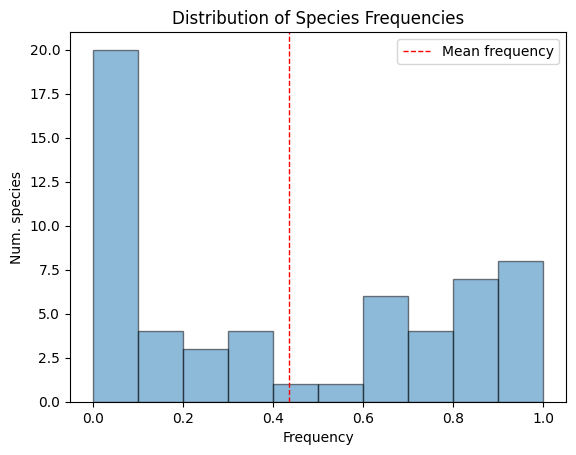

In [79]:
# Plot histogram of species frequencies and average frequency
plt.hist(x = species_abundance_and_frequency['Frequency'], bins = np.linspace(0, 1, 11), alpha = 0.5, histtype='bar', ec='black')
plt.axvline(mean_species_frequency, color='r', linestyle='dashed', linewidth=1, label = "Mean frequency")
plt.xlabel("Frequency")
plt.ylabel("Num. species")
plt.title("Distribution of Species Frequencies")
plt.legend()

The pictured histogram is similar in shape to the histogram of taxa frequencies, but because of the decreased number of taxa considered, there are smaller numbers of species in each interval of frequency. Isolating only the species-level taxa instead of also including the higher-level taxa lets us definitively conclude that we saw a ton of rarities (TODO: ask at what frequency level are we deeming a species a rarity)

### Calculate species-only Simpson and Shannon Diversity for all dates

In [53]:
species_date_simpson_diversity = [diversity_metrics.simpson_diversity(pc_species_only, date) for date in pc_dates]
species_date_shannon_diversity = [diversity_metrics.shannon_diversity(pc_species_only, date) for date in pc_dates]

In [90]:
species_simpson_and_shannon = pd.DataFrame()
species_simpson_and_shannon['Date'] = pc_dates
species_simpson_and_shannon['Species-only Simpson Diversity'] = species_date_simpson_diversity
species_simpson_and_shannon['Species-only Shannon Diversity'] = species_date_shannon_diversity
first_date = species_simpson_and_shannon['Date'][0]
species_simpson_and_shannon['Days Since First PC'] = pd.Series([(date - first_date).days for date in species_simpson_and_shannon['Date']])
species_simpson_and_shannon

,Date,Species-only Simpson Diversity,Species-only Shannon Diversity,Days Since First PC
0,2023-10-06,0.829753,2.154972,0
1,2023-10-12,0.844116,2.240913,6
2,2023-10-14,0.877765,2.515099,8
3,2023-10-20,0.744949,1.997706,14
4,2023-10-22,0.882832,2.613956,16
5,2023-10-25,0.738381,2.012080,19
6,2023-10-28,0.844900,2.335205,22
7,2023-10-31,0.885188,2.678579,25
8,2023-11-01,0.663229,1.745232,26
9,2023-11-05,0.894037,2.669617,30


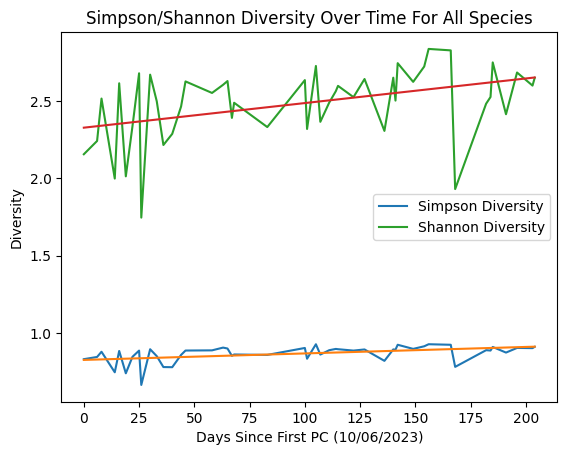

In [91]:
# Plot Simpson and Shannon Diversity for species, plus best fit lines.
plt.plot(species_simpson_and_shannon['Days Since First PC'], species_date_simpson_diversity, label = "Simpson Diversity")

species_simpson_regression_results = scipy.stats.linregress(species_simpson_and_shannon['Days Since First PC'],
                                                            species_date_simpson_diversity,
                                                            alternative = 'greater')
species_simpson_m, species_simpson_b = species_simpson_regression_results.slope, species_simpson_regression_results.intercept
plt.plot(species_simpson_and_shannon['Days Since First PC'],
         species_simpson_m * species_simpson_and_shannon['Days Since First PC'] + species_simpson_b)

plt.plot(species_simpson_and_shannon['Days Since First PC'], species_date_shannon_diversity, label = "Shannon Diversity")

species_shannon_regression_results = scipy.stats.linregress(species_simpson_and_shannon['Days Since First PC'],
                                                            species_date_shannon_diversity,
                                                            alternative = 'greater')
species_shannon_m, species_shannon_b = species_shannon_regression_results.slope, species_shannon_regression_results.intercept
plt.plot(species_simpson_and_shannon['Days Since First PC'],
         species_shannon_m * species_simpson_and_shannon['Days Since First PC'] + species_shannon_b)

plt.title("Simpson/Shannon Diversity Over Time For All Species")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Diversity")
plt.legend()

The above graph for Simpson and Shannon Diversity with only species-level taxa looks visually very similar to the Simpson and Shannon Diversity graph with all taxa included. (TODO: Add explanation for why), that probably has something to do with how the metrics are calculated.

See below for graphical comparisons of the two datasets.

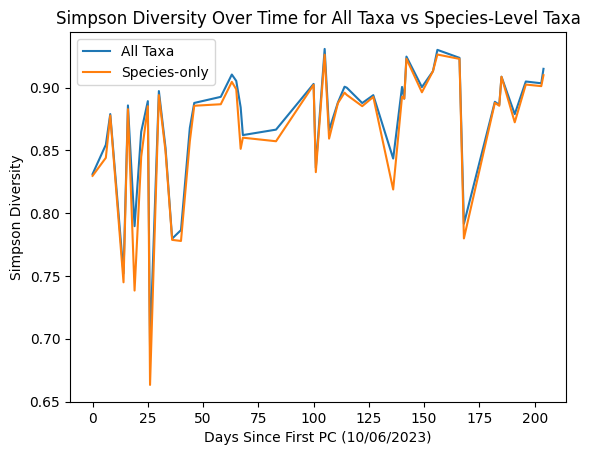

In [106]:
plt.plot(simpson_and_shannon['Days Since First PC'], date_simpson_diversity, label = "All Taxa")
plt.plot(species_simpson_and_shannon['Days Since First PC'], species_date_simpson_diversity, label = "Species-only")

plt.title("Simpson Diversity Over Time for All Taxa vs Species-Level Taxa")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Simpson Diversity")
plt.legend()

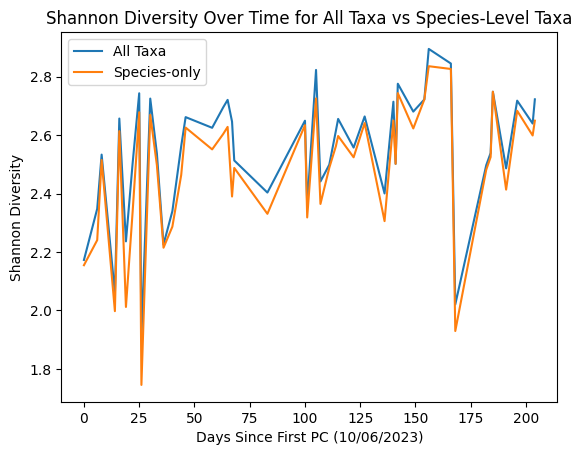

In [107]:
plt.plot(simpson_and_shannon['Days Since First PC'], date_shannon_diversity, label = "All Taxa")
plt.plot(species_simpson_and_shannon['Days Since First PC'], species_date_shannon_diversity, label = "Species-only")

plt.title("Shannon Diversity Over Time for All Taxa vs Species-Level Taxa")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Shannon Diversity")
plt.legend()

In [93]:
# Calculate mean and variance for Simpson and Shannon Diversity
mean_species_simpson, var_species_simpson = np.mean(species_simpson_and_shannon['Species-only Simpson Diversity']), np.var(species_simpson_and_shannon['Species-only Simpson Diversity'])
mean_species_shannon, var_species_shannon = np.mean(species_simpson_and_shannon['Species-only Shannon Diversity']), np.var(species_simpson_and_shannon['Species-only Shannon Diversity'])

print("Mean Species-only Simpson Diversity:", mean_species_simpson)
print("Species-only Simpson Diversity Variance:", var_species_simpson)
print("Mean Species-only Shannon Diversity:", mean_species_shannon)
print("Species-only Shannon Diversity Variance:", var_species_shannon)

Mean Species-only Simpson Diversity: 0.8656870270844976
Species-only Simpson Diversity Variance: 0.0029589212187229167
Mean Species-only Shannon Diversity: 2.4814211937359123
Species-only Shannon Diversity Variance: 0.0557858675415298


The species-only mean Simpson Diversity (0.866) was very close to the all-taxa mean Simpson Diversity (0.872), while there was a greater difference between the species-only mean Shannon Diversity (2.481) and the all-taxa mean Shannon Diversity (2.543). For both diversity metrics, the variances were higher for the diversity metrics calculated only using species level identifications (0.00296 vs 0.00239 for Simpson Diversity, and 0.0558 vs 0.0472 for Shannon Diversity). This could be because the species-only calculations have less observations, but I am not sure.

The relationship between Shannon Diversity and Simpson Diversity variances mentioned in the all-taxa analysis persists.

In [94]:
# Retrieve the p-values of the slopes for species-only Simpson and Shannon Diversity
print("Species-only Simpson Diversity Slope p-value:", species_simpson_regression_results.pvalue)
print("Species-only Shannon Diversity Slope p-value:", species_shannon_regression_results.pvalue)

Species-only Simpson Diversity Slope p-value: 0.0003294009291640946
Species-only Shannon Diversity Slope p-value: 0.0017397635124460197


The results of the significance tests on the species-only data further support the idea that Simpson and Shannon Diversity significantly increased over the survey period.

### Calculate species-only Alpha Diversity values across survey period

In [96]:
species_alpha_diversity = pd.DataFrame()
species_alpha_diversity['Date'] = pc_dates
species_alpha_diversity['Species-only Alpha Diversity'] = [diversity_metrics.alpha_diversity(pc_species_only, date) for date in pc_dates]
species_alpha_diversity['Days Since First PC'] = species_simpson_and_shannon['Days Since First PC']
species_alpha_diversity

,Date,Species-only Alpha Diversity,Days Since First PC
0,2023-10-06,1.205178,0
1,2023-10-12,1.184671,6
2,2023-10-14,1.139258,8
3,2023-10-20,1.342373,14
4,2023-10-22,1.132719,16
5,2023-10-25,1.354314,19
6,2023-10-28,1.183572,22
7,2023-10-31,1.129704,25
8,2023-11-01,1.507775,26
9,2023-11-05,1.118522,30


In [99]:
species_mean_alpha = np.mean(species_alpha_diversity['Species-only Alpha Diversity'])
species_var_alpha = np.var(species_alpha_diversity['Species-only Alpha Diversity'])

print("Species-only Mean Alpha Diversity:", species_mean_alpha)
print("Species-only Alpha Diversity Variance:", species_var_alpha)

Species-only Mean Alpha Diversity: 1.1603408657745016
Species-only Alpha Diversity Variance: 0.006888809886392081


The species-only mean and variance for Alpha Diversity are very similar to the all-taxa mean and variance for Alpha Diversity (1.150 and 0.00516 respectively), although the difference in values between the two datasets is larger for variance.

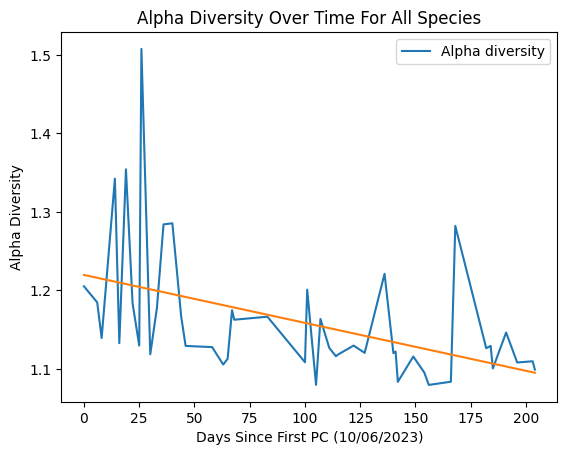

In [100]:
# Plot species-only Alpha Diversity for each date, plus best fit line.
# As described earlier, the scipy.stats.linregress method is used for easier downstream analysis.

plt.plot(species_alpha_diversity['Days Since First PC'], species_alpha_diversity['Species-only Alpha Diversity'], label = "Alpha diversity")

species_alpha_diversity_regression_results = scipy.stats.linregress(species_alpha_diversity['Days Since First PC'],
                                                            species_alpha_diversity['Species-only Alpha Diversity'])
species_alpha_m, species_alpha_b = species_alpha_diversity_regression_results.slope, species_alpha_diversity_regression_results.intercept
plt.plot(species_alpha_diversity['Days Since First PC'],
         species_alpha_m * species_alpha_diversity['Days Since First PC'] + species_alpha_b)

plt.title("Alpha Diversity Over Time For All Species")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Alpha Diversity")
plt.legend()

The above graph displays the Alpha Diversity for all species-level taxa plotted over time, starting from the first point count. The overall trend seems to be the same as the Alpha Diversity for all taxa, but some of the peaks pictured in the species-only graph seem to be more extreme. For a comparison of the two datasets, view the graph below.

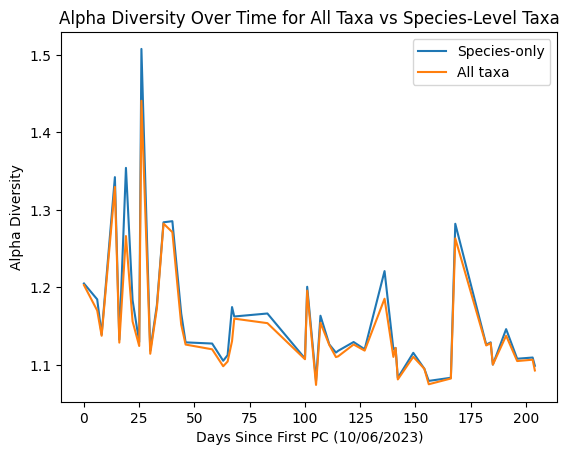

In [104]:
plt.plot(species_alpha_diversity['Days Since First PC'], species_alpha_diversity['Species-only Alpha Diversity'], label = "Species-only")
plt.plot(alpha_diversity['Days Since First PC'], alpha_diversity['Alpha Diversity'], label = "All taxa")

plt.title("Alpha Diversity Over Time for All Taxa vs Species-Level Taxa")
plt.xlabel("Days Since First PC (10/06/2023)")
plt.ylabel("Alpha Diversity")
plt.legend()

In [108]:
# Retrieve the p-value of the slope for species-only alpha diversity
print("Species-Only Alpha Diversity Slope p-value:", species_alpha_diversity_regression_results.pvalue)

Species-Only Alpha Diversity Slope p-value: 0.0012511867681960828


Using the same p-value (0.05) for the significance analysis, I can also reject the null hypothesis (`species_alpha_m` = 0), as p = 0.00125 \< 0.05, and conclude that alpha diversity for species-level taxa experienced a significant decrease across the survey period.

### Compile all data